In [30]:
pip install pycnv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 514.9 kB/s eta 0:00:00a 0:00:02
  Created wheel for pycnv: filename=pycnv-0.4.8-py3-none-any.whl size=42895 sha256=f06fa40fd69bbda04e8015c011fd11cdaff3f3c7f24f8673d4b3ae62fc70cd01
  Stored in directory: /Users/gonzaloruiz/Library/Caches/pip/wheels/14/f8/fe/5f979cba42de7da1bcbc4cd5e26c19801c6890cb404c45c628
Successfully built pycnv
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install gsw

In [2]:
import csv
import gsw
import numpy as np
import pycnv
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

## DAY 1

In [219]:
fname = 'CTD_03_avg.cnv'
cnv = pycnv.pycnv(fname)
print('Test if we are in the Baltic Sea (usage of different equation of state): ' + str(cnv.baltic))
print('Position of cast is: Longitude:', cnv.lon,'Latitude:',cnv.lat)
print('Time of cast was:', cnv.date)
print('Number of sensor entries (len(cnv.data.keys())):',len(cnv.data.keys()))
print('Names of sensor entries (cnv.data.keys()):',cnv.data.keys())

INFO:pycnv: Opening file: CTD_03_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm


Date
Computing date
Test if we are in the Baltic Sea (usage of different equation of state): True
Position of cast is: Longitude: 10.917 Latitude: 57.456
Time of cast was: 2025-05-06 12:58:41+00:00
Number of sensor entries (len(cnv.data.keys())): 18
Names of sensor entries (cnv.data.keys()): dict_keys(['scan', 'prDM', 'p', 't090C', 'T0', 'c0S/m', 'C0', 'flECO-AFL', 'sbeox0V', 'oxy0', 'turbWETntu0', 'turb', 'depSM', 'depSM@7', 'sal00', 'sbeox0Mm/L', 'sbeox0PS', 'flag'])


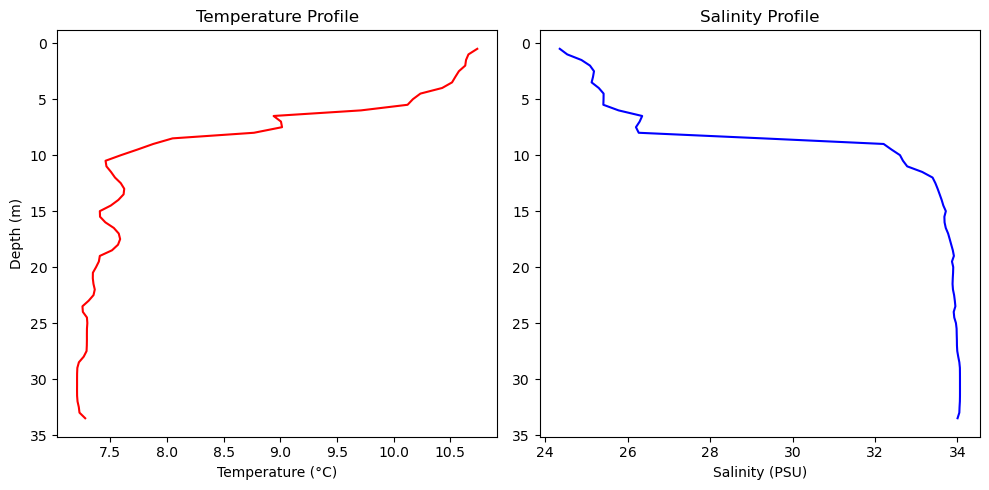

In [221]:
depth = cnv.data['depSM']      
temperature = cnv.data['t090C'] 
salinity = cnv.data['sal00']   

plt.figure(figsize=(10, 5))

# Plot Temperature
plt.subplot(1, 2, 1)
plt.plot(temperature, depth, 'r')
plt.gca().invert_yaxis()  # Depth increases downward
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (m)')
plt.title('Temperature Profile')

# Plot Salinity
plt.subplot(1, 2, 2)
plt.plot(salinity, depth, 'b')
plt.gca().invert_yaxis()
plt.xlabel('Salinity (PSU)')
plt.title('Salinity Profile')

plt.tight_layout()
plt.show()

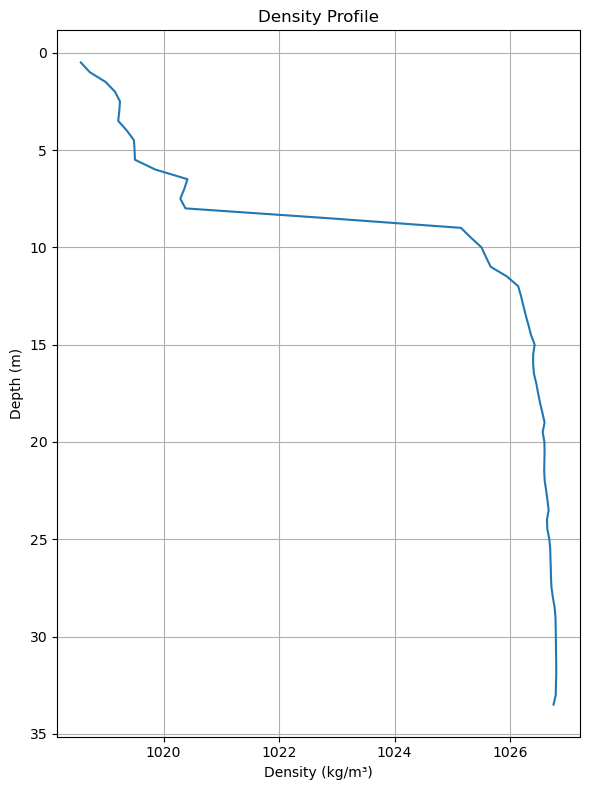

In [223]:
sal = np.array(cnv.data['sal00'])      # Practical Salinity (PSU)
temp = np.array(cnv.data['t090C'])     # In-situ temperature (°C)
pres = np.array(cnv.data['prDM'])      # Pressure (dbar)
lat = cnv.lat
lon = cnv.lon

# Convert to Absolute Salinity (g/kg)
SA = gsw.SA_from_SP(sal, pres, lon, lat)

# Convert to Conservative Temperature (°C)
CT = gsw.CT_from_t(SA, temp, pres)

# Calculate in-situ density (kg/m^3)
rho = gsw.rho(SA, CT, pres)

depth = cnv.data['depSM']
plt.figure(figsize=(6, 8))
plt.plot(rho, depth)
plt.gca().invert_yaxis()
plt.xlabel('Density (kg/m³)')
plt.ylabel('Depth (m)')
plt.title('Density Profile')
plt.grid()
plt.tight_layout()
plt.savefig('density_profile.png')
plt.show()

In [225]:
fname = 'CTD_01_avg.cnv'
folder_name = os.path.splitext(fname)[0]

# Create folder if it doesn't exist
os.makedirs(folder_name, exist_ok=True)

# Extract variables
depth = cnv.data['depSM']
temperature = cnv.data['t090C']
salinity = cnv.data['sal00']
oxygen = cnv.data.get('oxy0')
fluorescence = cnv.data.get('flECO-AFL')
turbidity = cnv.data.get('turb')

# Plotting function
def plot_profile(x, y, xlabel, title, filename):
    plt.figure(figsize=(6, 8))
    plt.plot(x, y)
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Depth (m)')
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(folder_name, filename))
    plt.close()

# Plot and save each variable
plot_profile(temperature, depth, 'Temperature (°C)', 'Temperature Profile', 'temperature_profile.png')
plot_profile(salinity, depth, 'Salinity (PSU)', 'Salinity Profile', 'salinity_profile.png')

if oxygen is not None:
    plot_profile(oxygen, depth, 'Oxygen (µmol/L or similar)', 'Oxygen Profile', 'oxygen_profile.png')

if fluorescence is not None:
    plot_profile(fluorescence, depth, 'Fluorescence (A.U.)', 'Fluorescence Profile', 'fluorescence_profile.png')

if turbidity is not None:
    plot_profile(turbidity, depth, 'Turbidity (NTU or A.U.)', 'Turbidity Profile', 'turbidity_profile.png')

print(f"All plots saved in folder: {folder_name}")


All plots saved in folder: CTD_01_avg


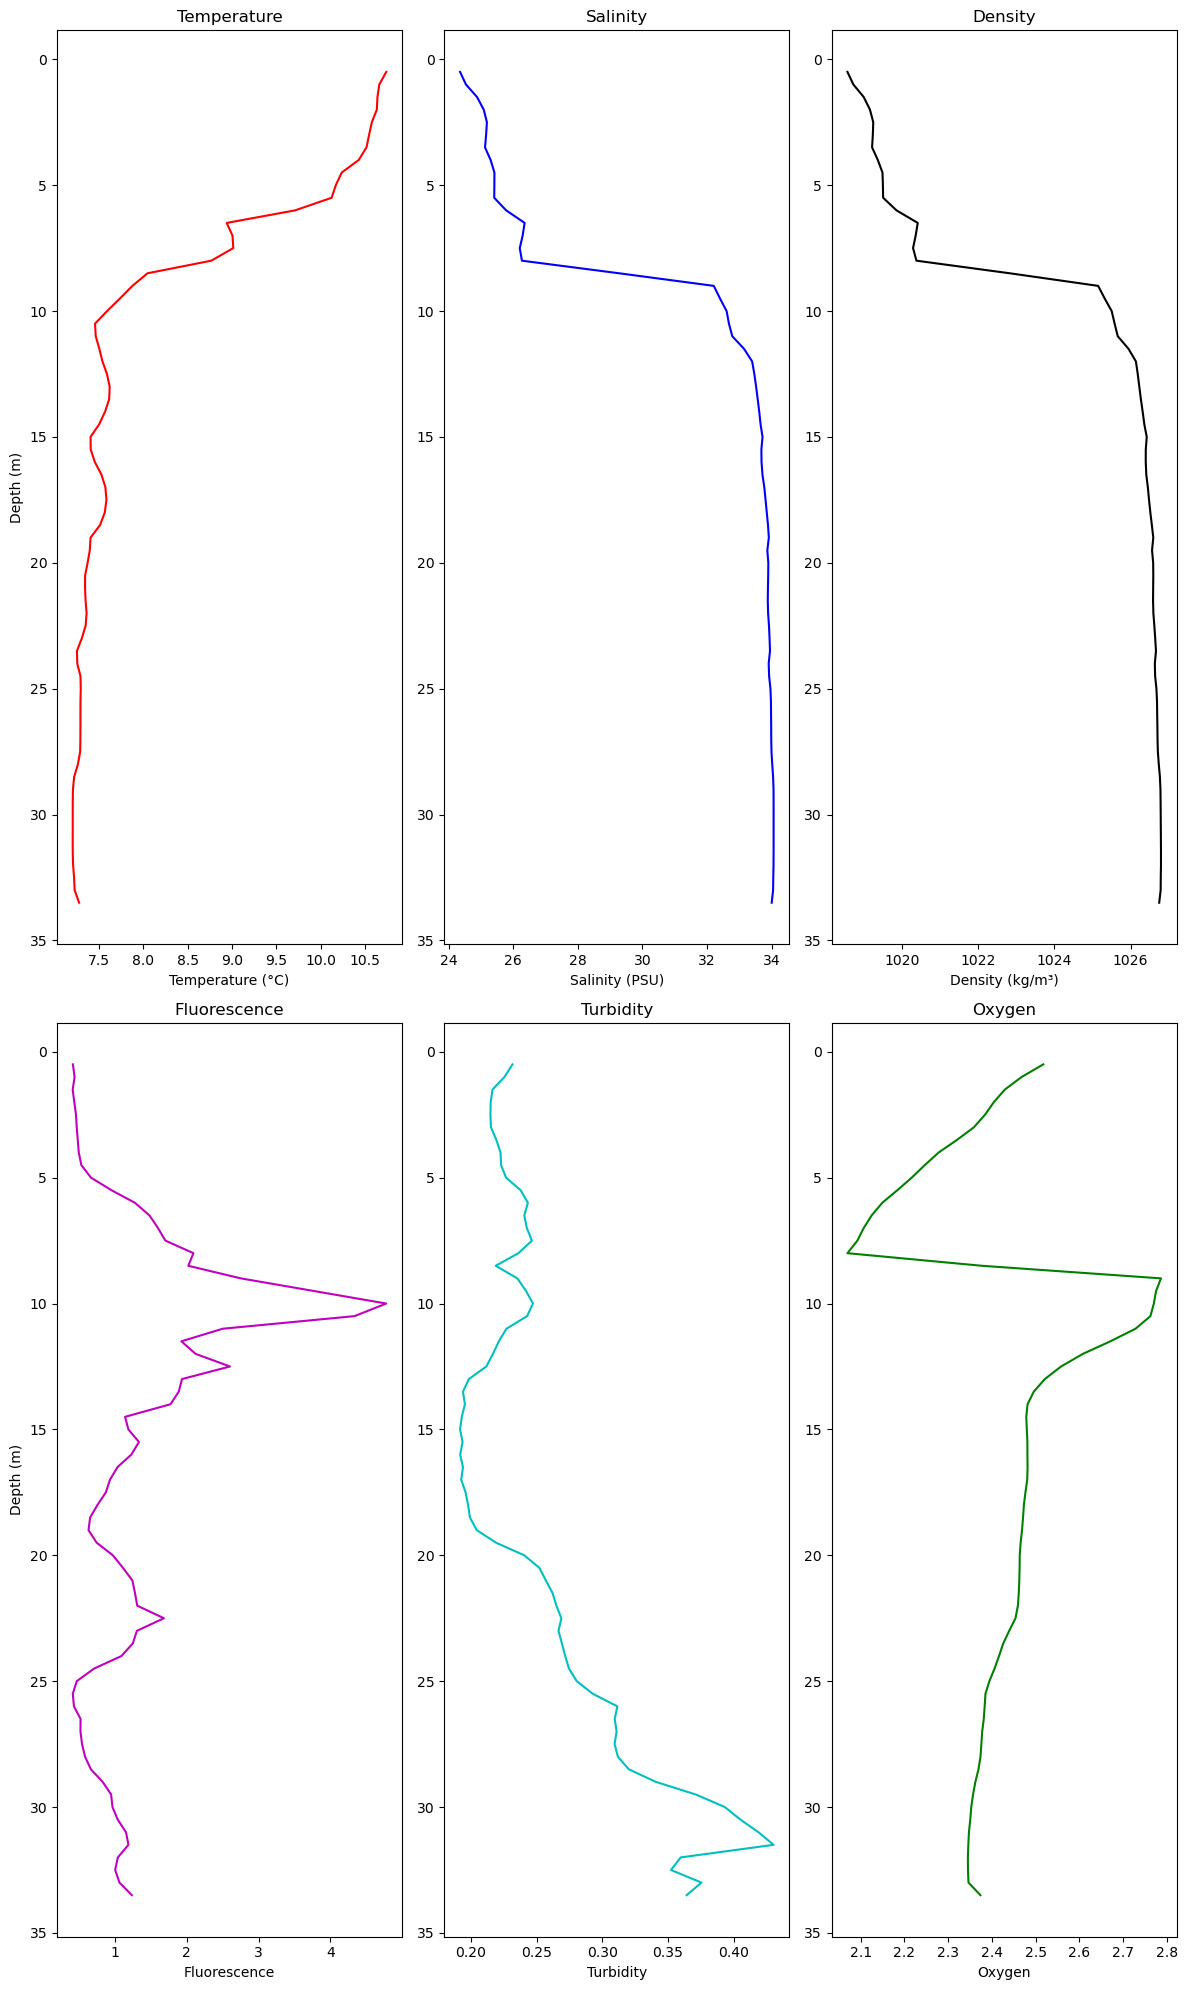

In [226]:
depth = cnv.data['depSM']
temperature = np.array(cnv.data['t090C'])
salinity = np.array(cnv.data['sal00'])
pressure = np.array(cnv.data['prDM'])
oxygen = np.array(cnv.data['oxy0'])
fluorescence = np.array(cnv.data['flECO-AFL'])
turbidity = np.array(cnv.data['turb'])

# Compute density using TEOS-10 (gsw)
SA = gsw.SA_from_SP(salinity, pressure, cnv.lon, cnv.lat)
CT = gsw.CT_from_t(SA, temperature, pressure)
density = gsw.rho(SA, CT, pressure)

# Create a 3x2 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(12, 20))

# Temperature
axs[0, 0].plot(temperature, depth, 'r')
axs[0, 0].invert_yaxis()
axs[0, 0].set_xlabel('Temperature (°C)')
axs[0, 0].set_ylabel('Depth (m)')
axs[0, 0].set_title('Temperature')

# Salinity
axs[0, 1].plot(salinity, depth, 'b')
axs[0, 1].invert_yaxis()
axs[0, 1].set_xlabel('Salinity (PSU)')
axs[0, 1].set_title('Salinity')

# Oxygen
axs[1, 2].plot(oxygen, depth, 'g')
axs[1, 2].invert_yaxis()
axs[1, 2].set_xlabel('Oxygen')
axs[1, 2].set_title('Oxygen')

# Fluorescence
axs[1, 0].plot(fluorescence, depth, 'm')
axs[1, 0].invert_yaxis()
axs[1, 0].set_xlabel('Fluorescence')
axs[1, 0].set_ylabel('Depth (m)')
axs[1, 0].set_title('Fluorescence')

# Turbidity
axs[1, 1].plot(turbidity, depth, 'c')
axs[1, 1].invert_yaxis()
axs[1, 1].set_xlabel('Turbidity')
axs[1, 1].set_title('Turbidity')

# Density
axs[0, 2].plot(density, depth, 'k')
axs[0, 2].invert_yaxis()
axs[0, 2].set_xlabel('Density (kg/m³)')
axs[0, 2].set_title('Density')

plt.tight_layout()
plt.show()


**Potential density**

In [231]:
sigma0 = gsw.density.sigma0(SA,CT)

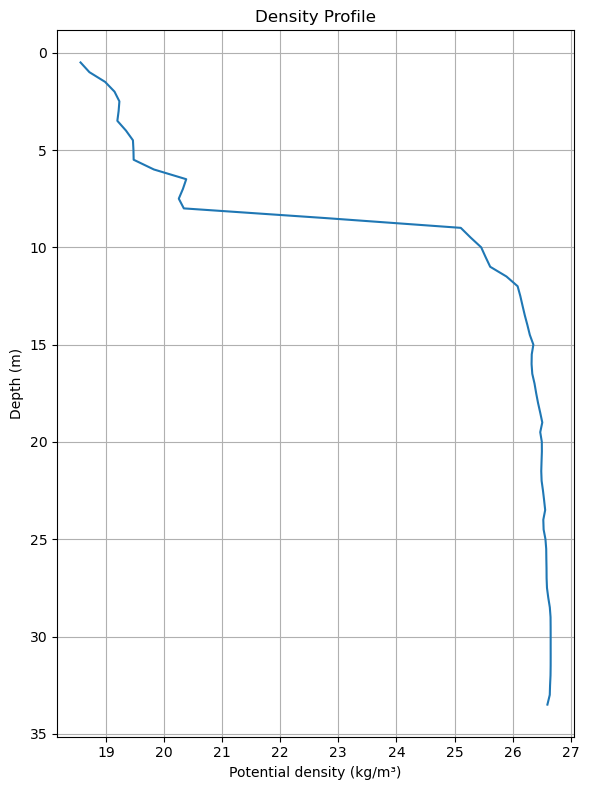

In [234]:
depth = cnv.data['depSM']
plt.figure(figsize=(6, 8))
plt.plot(sigma0, depth)
plt.gca().invert_yaxis()
plt.xlabel('Potential density (kg/m³)')
plt.ylabel('Depth (m)')
plt.title('Density Profile')
plt.grid()
plt.tight_layout()
plt.savefig('potential_density_profile.png')
plt.show()

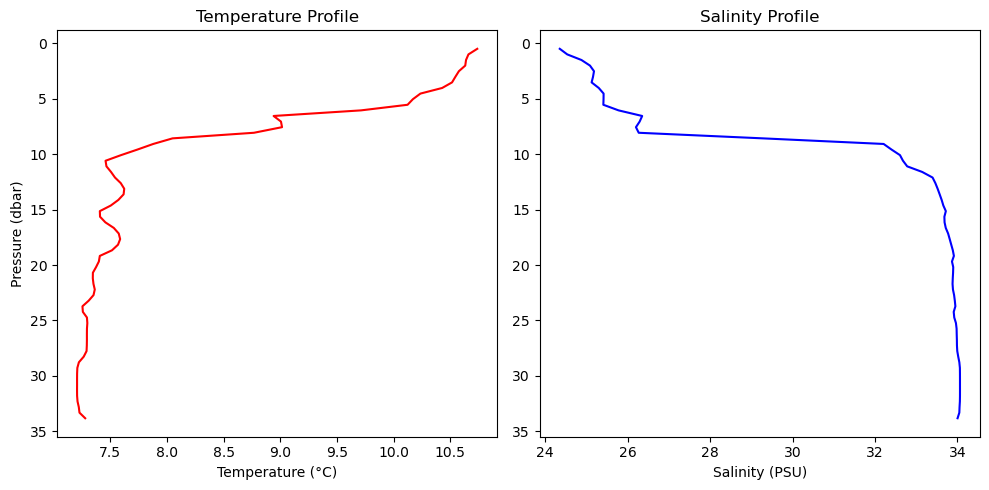

In [236]:
pressure = cnv.data['p']      
temperature = cnv.data['t090C'] 
salinity = cnv.data['sal00']   

plt.figure(figsize=(10, 5))

# Plot Temperature
plt.subplot(1, 2, 1)
plt.plot(temperature, pressure, 'r')
plt.gca().invert_yaxis()  # Depth increases downward
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (dbar)')
plt.title('Temperature Profile')

# Plot Salinity
plt.subplot(1, 2, 2)
plt.plot(salinity, pressure, 'b')
plt.gca().invert_yaxis()
plt.xlabel('Salinity (PSU)')
plt.title('Salinity Profile')

plt.tight_layout()
plt.show()

In [238]:
cnv.lat

57.456

In [240]:
cnv.lon

10.917

## CTD COMBINATION - T-S PLOT

In [243]:
# Prepare lists to collect all temperature and salinity values
all_temp = []
all_sali = []

# Loop through CTD_01_avg.cnv to CTD_04_avg.cnv
for i in range(1, 5):
    fname = f'CTD_0{i}_avg.cnv'
    cnv = pycnv.pycnv(fname)
    
    temperature = cnv.data['t090C']
    salinity = cnv.data['sal00']
    
    all_temp.extend(temperature)
    all_sali.extend(salinity)

# Convert to NumPy arrays if needed
all_temp = np.array(all_temp)
all_sali = np.array(all_sali)

print(f"Combined temperature size: {all_temp.shape}")
print(f"Combined salinity size: {all_sali.shape}")


INFO:pycnv: Opening file: CTD_01_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: CTD_02_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: CTD_03_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm
INFO:pycnv: Opening file: CTD_04_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm


Date
Computing date
Date
Computing date
Date
Computing date
Date
Computing date
Combined temperature size: (273,)
Combined salinity size: (273,)


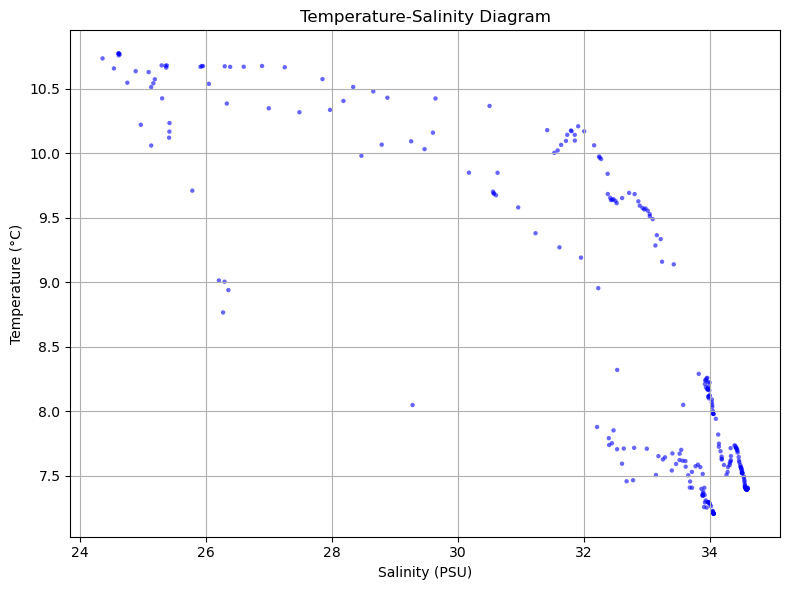

In [245]:
plt.figure(figsize=(8, 6))
plt.scatter(all_sali, all_temp, c='blue', s=10, alpha=0.6, edgecolors='none')
plt.xlabel('Salinity (PSU)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature-Salinity Diagram')
plt.grid(True)
plt.tight_layout()
plt.show()


## MULTIPANEL CREATION

In [253]:
fname = 'CTD_04_avg.cnv'
cnv = pycnv.pycnv(fname)

basename = os.path.splitext(fname)[0]              
plot_name = basename.replace('_avg', '') + '_multipanel'  
plot_dir = 'Plots'
os.makedirs(plot_dir, exist_ok=True)

depth = cnv.data['depSM']
temperature = np.array(cnv.data['t090C'])
salinity = np.array(cnv.data['sal00'])
pressure = np.array(cnv.data['prDM'])
oxygen = np.array(cnv.data['oxy0'])
fluorescence = np.array(cnv.data['flECO-AFL'])
turbidity = np.array(cnv.data['turb'])

SA = gsw.SA_from_SP(salinity, pressure, cnv.lon, cnv.lat)
CT = gsw.CT_from_t(SA, temperature, pressure)
sigma0 = gsw.density.sigma0(SA,CT)

INFO:pycnv: Opening file: CTD_04_avg.cnv
INFO:pycnv:Converting conductivity units from S/m to mS/cm


Date
Computing date


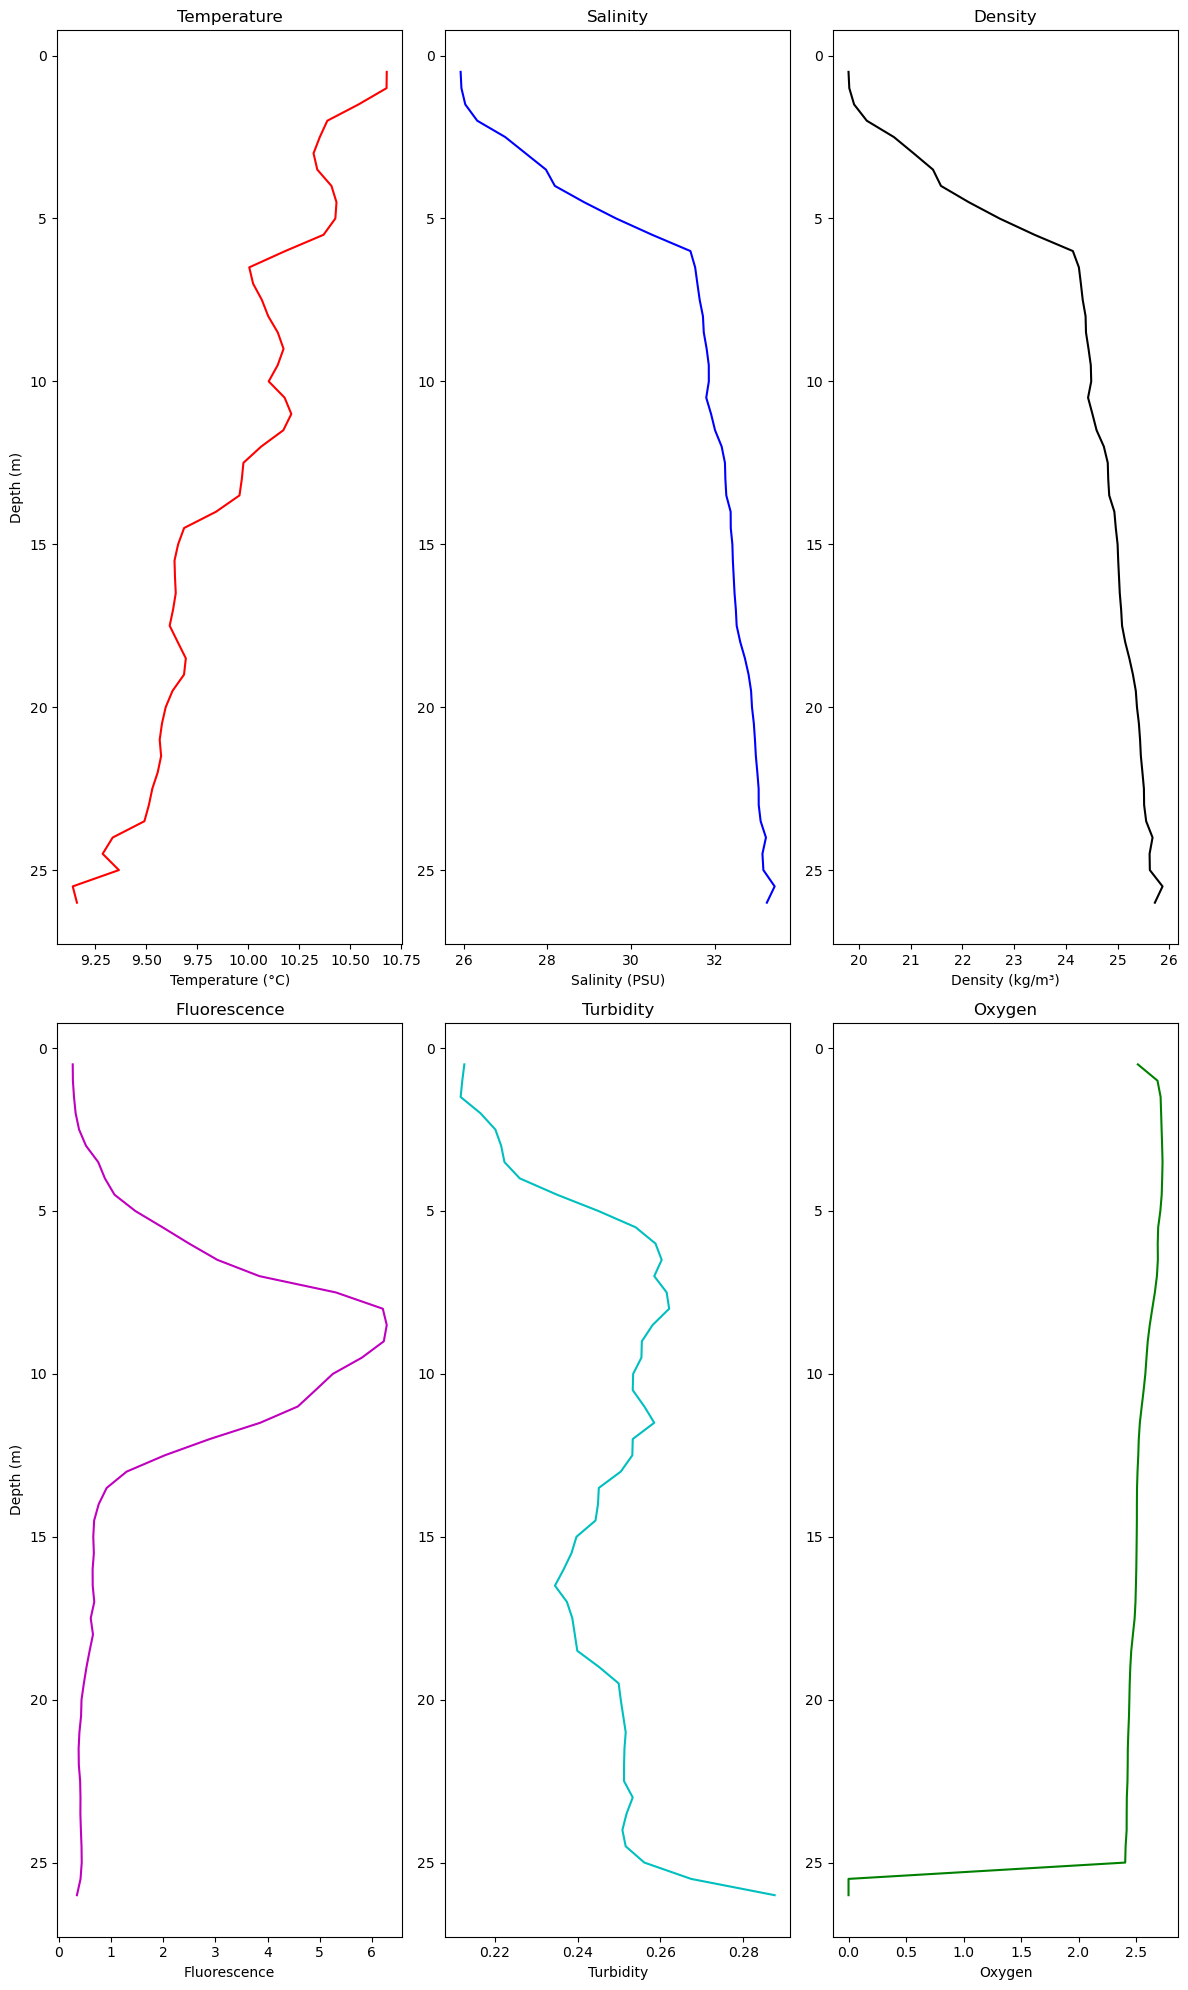

Plot saved to: Plots/CTD_04_multipanel.png


In [255]:
fig, axs = plt.subplots(2, 3, figsize=(12, 20))

axs[0, 0].plot(temperature, depth, 'r')
axs[0, 0].invert_yaxis()
axs[0, 0].set_xlabel('Temperature (°C)')
axs[0, 0].set_ylabel('Depth (m)')
axs[0, 0].set_title('Temperature')

axs[0, 1].plot(salinity, depth, 'b')
axs[0, 1].invert_yaxis()
axs[0, 1].set_xlabel('Salinity (PSU)')
axs[0, 1].set_title('Salinity')

axs[1, 2].plot(oxygen, depth, 'g')
axs[1, 2].invert_yaxis()
axs[1, 2].set_xlabel('Oxygen')
axs[1, 2].set_title('Oxygen')

axs[1, 0].plot(fluorescence, depth, 'm')
axs[1, 0].invert_yaxis()
axs[1, 0].set_xlabel('Fluorescence')
axs[1, 0].set_ylabel('Depth (m)')
axs[1, 0].set_title('Fluorescence')

axs[1, 1].plot(turbidity, depth, 'c')
axs[1, 1].invert_yaxis()
axs[1, 1].set_xlabel('Turbidity')
axs[1, 1].set_title('Turbidity')

axs[0, 2].plot(sigma0, depth, 'k')
axs[0, 2].invert_yaxis()
axs[0, 2].set_xlabel('Density (kg/m³)')
axs[0, 2].set_title('Density')

plt.tight_layout()

output_path = os.path.join(plot_dir, plot_name + '.png')
plt.savefig(output_path, dpi=300)
plt.show()
print(f"Plot saved to: {output_path}")